The City of Chicago has made it's police database available from it's city data hub.

I'm curious about what it shows about accidents involving bicycles and, specifically, what happened during covid.

Allegedly, more people started biking in 2020 because public transit was either limited or perceived to be unsafe; many bike shops reported they couldn't keep up with demand (with supply chain problems doubtless contributing to the problem).

But drivers -- taking advantage of fewer cars on the road -- allegedly began to drive faster and more recklessly.

Questions:
    1) Was there an increase in the amount of bicycling being done during 2020? This question is better answered by analyzing DIVVY data. This cannot show how private bike use changed, but it can show whether there was an uptick in the amount of useage with the DIVVY system.
    2) Was there an increase in the number of bike accidents in 2020? This might suggest either/both more bikes on the road and/or more reckless driving being done.

To access the Chicago databases, one needs an API app token. One needs to create an account on their website (https://data.cityofchicago.org/login) and then go to the developer settings page (https://data.cityofchicago.org/profile/edit/developer_settings)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from sodapy import Socrata

In [2]:
print('Enter App Token')
AppTok = input()

Enter App Token


One can query the city's database with a URL like this one:
    url= "https://data.cityofchicago.org/resource/85ca-t3if.json?$$app_token=AppTok$where=crash_date%20between$20'2021-01-01T00:00:00'%20and%20'2022-01-01T00:00:00'"

but it is clearer to use the Socrata client and sodapy. The syntax for it is a little confusing and the next few cells show my trial- and error-efforts to get the syntax correct.

One problem is that the URL method returns a JSON object, which Pandas does a better job of turning into a DF: numbers are recognized as numbers, mostly.

The Socrata client returns a list/dictionary and Pandas turns all the fields into string objects.

In [3]:
client=Socrata('data.cityofchicago.org',AppTok)
# chicago data, App_token


In [ ]:
results=client.get('85ca-t3if',limit=2000)
# this works - pulls 2K crash records
len(results)

In [15]:
results2 = client.get('85ca-t3if',where="first_crash_type== 'PEDALCYCLIST'",limit=2000)
len(results2)

2000

In [14]:
results3 = client.get('85ca-t3if',where= "crash_date>'21-01-01T00:00:00'",limit=2000)
len(results3)

2000

The above cells are my experiments to get the syntax of the query correct. The documentation isn't terribly helpful about how to format the "where" statement. What I found was:

a) field names don't need to be in quotes but the criteria do:
    first_crash_type (field name) == 'PEDALCYCLIST' (criteria)
b) Socrata supports multiple criterial; each needs to follow the above format:
    where= "crash_date>'19-01-01T00:00:00'" and "first_crash_type== 'PEDALCYCLIST'"

In [4]:
results = client.get('85ca-t3if', 
    where= "crash_date>'18-01-01T00:00:00'" and "first_crash_type== 'PEDALCYCLIST'",
    limit = 50000)    

In [21]:
results_JSON = client.get('85ca-t3if', content_type= 'json',
    where= "crash_date>'18-01-01T00:00:00'" and "first_crash_type== 'PEDALCYCLIST'",
    limit = 50000) 

In [22]:
crashes_json = pd.DataFrame.from_dict(results_JSON)

In [5]:
crashes = pd.DataFrame.from_dict(results)
len(crashes)

9253

In [20]:
crashes.dtypes

crash_record_id                          object
crash_date                       datetime64[ns]
posted_speed_limit                       object
traffic_control_device                   object
device_condition                         object
weather_condition                        object
lighting_condition                       object
first_crash_type                         object
trafficway_type                          object
alignment                                object
roadway_surface_cond                     object
road_defect                              object
report_type                              object
crash_type                               object
intersection_related_i                   object
damage                                   object
date_police_notified                     object
prim_contributory_cause                  object
sec_contributory_cause                   object
street_no                                object
street_direction                        

Since Jan 2019 to July 2022, there are only 9253 reports of crashes involving bicyclists? This seems low. Let's chart it by year to see if there are major differences. . .

First a bit of data cleaning, including changing the date field to datetime format

In [6]:
crashes.crash_date = pd.to_datetime(crashes.crash_date)

In [11]:
crashes['crash_year'] = crashes['crash_date'].dt.year

In [24]:
crashes['posted_speed_limit'] = pd.to_numeric(crashes['posted_speed_limit'])
crashes['crash_month'] = pd.to_numeric(crashes['crash_month'])
crashes['beat_of_occurrence'] = pd.to_numeric( crashes['beat_of_occurrence'] )
crashes['injuries_total'] = pd.to_numeric(crashes['injuries_total'])
crashes['crash_hour'] = pd.to_numeric( crashes['crash_hour'] )
crashes['crash_year'] = pd.to_numeric( crashes['crash_year'] )
crashes['crash_day_of_week'] = pd.to_numeric( crashes['crash_day_of_week'] )
crashes['latitude'] = pd.to_numeric( crashes['latitude'] )
crashes['longitude'] = pd.to_numeric( crashes['longitude'] )


In [64]:
crashes.dtypes

crash_record_id                          object
crash_date                       datetime64[ns]
posted_speed_limit                        int64
traffic_control_device                   object
device_condition                         object
weather_condition                        object
lighting_condition                       object
first_crash_type                         object
trafficway_type                          object
alignment                                object
roadway_surface_cond                     object
road_defect                              object
report_type                              object
crash_type                               object
intersection_related_i                   object
damage                                   object
date_police_notified                     object
prim_contributory_cause                  object
sec_contributory_cause                   object
street_no                                object
street_direction                        

<AxesSubplot:title={'center':'Annual N of Reported Crashes'}>

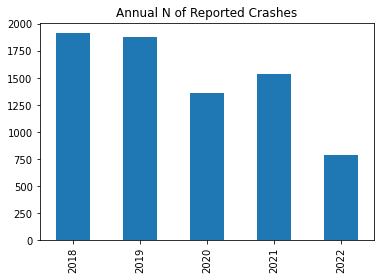

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline 
crashes['crash_year'].value_counts().sort_index().plot.bar(title='Annual N of Reported Crashes')

Hard to know how to interpret this. The dataset was created in October 2017 (https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if), so it's likely that the data from before January 2018 is not recorded in the same fashion. Let's dump the pre-2018 data from our analysis. . . 

In [13]:
len(crashes[crashes['crash_year']<2018])

1755

So we're going to dump roughly 1700 records.

In [15]:
crashes = crashes[crashes['crash_year']>2017]
len(crashes)

7498

<AxesSubplot:title={'center':'Annual N of Reported Crashes'}>

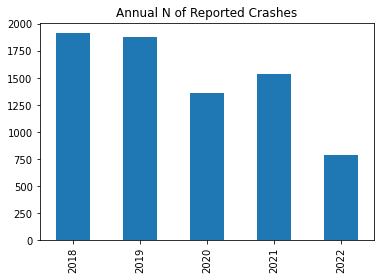

In [16]:
crashes['crash_year'].value_counts().sort_index().plot.bar(title='Annual N of Reported Crashes')

This graph shows that there were significantly fewer crashes reported in 2020 than in the two years prior. 2021 saw an increase, but not to the prior levels.

Let's break it out by month, so we can compare what's going on annually . . 

<AxesSubplot:title={'center':'Bicycle crashes by Month'}>

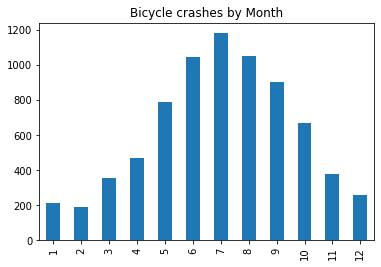

In [29]:
crashes['crash_month'].value_counts().sort_index().plot.bar(title='Bicycle crashes by Month')

To do this, we can use a pivot table to summarize the data, annually and by month.

In a lot of records (>2000!), the "injuries_total" is zero, so it's better to count them then to sum them!

In [59]:
crashes_pivoted = crashes.pivot_table(index = 'crash_month',
    columns = 'crash_year', 
    values = 'injuries_total',
    aggfunc = 'count'
    )

In [60]:
crashes_pivoted

crash_year,2018,2019,2020,2021,2022
crash_month,,,,,
1,57.0,44.0,46.0,38.0,28.0
2,45.0,45.0,51.0,14.0,32.0
3,76.0,76.0,55.0,70.0,76.0
4,103.0,126.0,36.0,104.0,100.0
5,216.0,158.0,90.0,144.0,182.0
6,235.0,219.0,161.0,198.0,233.0
7,289.0,294.0,227.0,229.0,143.0
8,304.0,291.0,243.0,213.0,NaN
9,253.0,257.0,191.0,203.0,NaN


Text(0.5, 0, 'Month of Year')

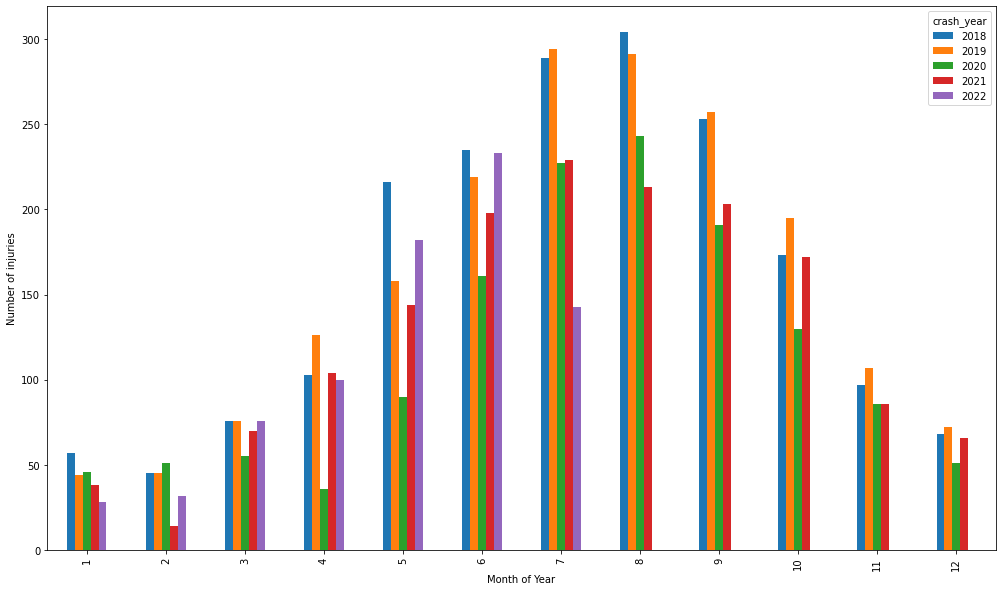

In [67]:
crashes_pivoted.plot(kind ='bar',figsize=(17,10))
plt.ylabel('Number of injuries')
plt.xlabel('Month of Year')


This graph shows the effects of Covid on the accidents reporting starkly.

Recall that in Jan and Feb, Covid was mostly seen as a foreign problem, first in China, then in Europe. On March 13, President Trump declared a nationwide emergency and states began to shutdown schools and businesses. Some states began to roll these restrictions back as early as late April, but Chicago continued to have strong restrictions throughout 2020. (https://www.cdc.gov/museum/timeline/covid19.html)

This timeline is reflected in the graph above. In Jan and Feb, the N reported in 2020 was very similar to the figures from 2018 and 2019. In March, the number dips and in April and May plummets. 

Bike accident reports are not evenly distributed across the city. Rather, they tend to be clustered in certain police beats. Let's examine this.

<AxesSubplot:title={'center':'Pct of reports by police beat'}>

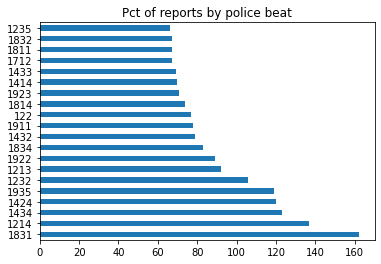

In [69]:
crashes['beat_of_occurrence'].value_counts().head(20).plot.barh(title='Pct of reports by police beat')

Its clear that 1831 and 1213 are far ahead of some of the other beats. Does this vary by year? Again, we can look at this with a pivot table.

In [84]:
beats_pivoted = crashes.pivot_table(index = 'beat_of_occurrence',
    columns = 'crash_year', 
    values = 'injuries_total',
    aggfunc = 'count',
    margins = True, margins_name='Total'
    )

In [85]:
beats_pivoted

crash_year,2018,2019,2020,2021,2022,Total
beat_of_occurrence,,,,,,
111,16.0,10.0,1.0,10.0,7.0,44
112,8.0,10.0,1.0,11.0,4.0,34
113,3.0,4.0,5.0,5.0,1.0,18
114,13.0,16.0,12.0,15.0,6.0,62
121,16.0,19.0,4.0,13.0,4.0,56
...,...,...,...,...,...,...
2532,1.0,2.0,2.0,NaN,NaN,5
2533,7.0,7.0,4.0,11.0,2.0,31
2534,6.0,9.0,4.0,8.0,4.0,31


In [88]:
bp_sorted = beats_pivoted.sort_values(by=('Total'),ascending=False)

<AxesSubplot:ylabel='beat_of_occurrence'>

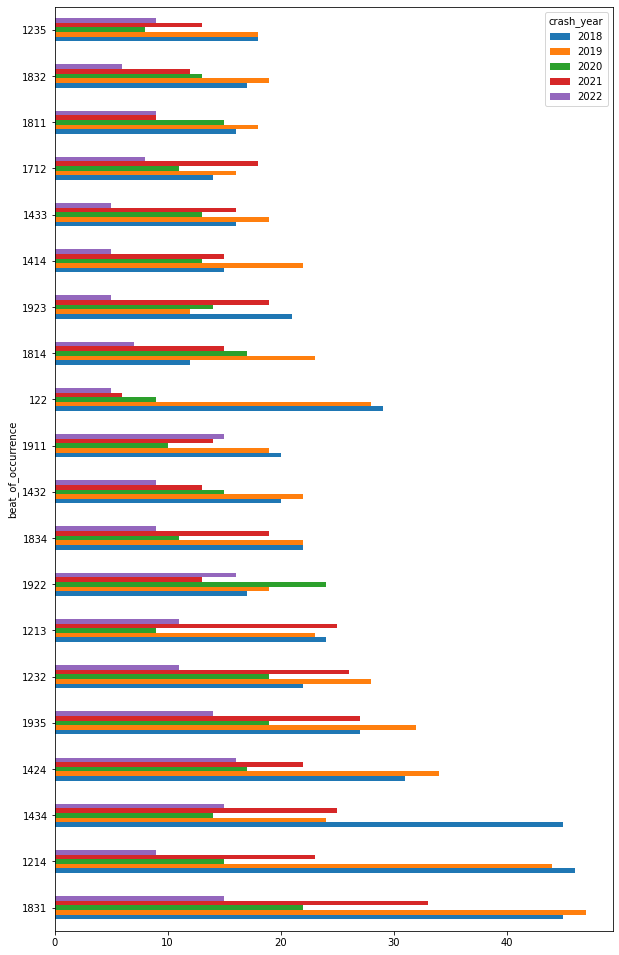

In [93]:
bp_sorted.iloc[1:21,0:5].plot(kind ='barh',figsize=(10,17))